In [ ]:
!gsutil cp gs://cloud-training-demos/courses/machine_learning/deepdive/09_sequence/text_classification/glove.6B.200d.txt glove.6B.200d.txt

Copying gs://cloud-training-demos/courses/machine_learning/deepdive/09_sequence/text_classification/glove.6B.200d.txt...
\ [1 files][661.3 MiB/661.3 MiB]                                                
Operation completed over 1 objects/661.3 MiB.                                    


In [ ]:
import pandas as pd
import unicodedata
import os
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.utils import shuffle
import numpy as np

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data_save = data
data = data[["id","original_text","sentiment_class"]]

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

collection = contraction_mapping.keys()

def expand_words(s):
    #unicode_data = s
    #w = unicodedata.normalize('NFKD', unicode_data).encode('ASCII', 'ignore')
    #w = str(w)[2:len(w)-1]
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    words = []
    s = list(s.split(' '))
    for i in s:
      if i in collection:
          ch = contraction_mapping[i]
      else:
          ch = i
      words.append(ch)

    str1 = ""
    for i in words:
      str1 = str1 + " " + i
    str1.lstrip()
    #str1.trim()
    return str1
    


In [ ]:
def clean(text):
    # fill the missing entries and convert them to lower case
    text = text.fillna("fillna").str.lower()
    #remove all special characters
    text = text.map(lambda x: re.sub('[^A-Za-z0-9]+',' ',str(x)))
    # replace the newline characters with space 
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    # remove usernames and links
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

In [ ]:
import re

In [ ]:
#data['original_text'] = [clean(i) for i in data['original_text']]
data['original_text'] = [expand_words(i) for i in data.original_text]

#data['original_text'] = [clean(i) for i in data['original_text']]
data['original_text'] = clean(data['original_text'])

#Converting the Labels 0 -> Negative , 1 - > Neutral 2 -> Positive 
data["sentiment_class"] = [i+1 for i in data.sentiment_class]
data.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,id,original_text,sentiment_class
0,1.245025e+18,happy mothersday to all you amazing mothers o...,1
1,1.245759e+18,happy mothers day mum i am sorry i cannot be ...,1
2,1.246087e+18,happy mothers day to all this doing a mothers...,0
3,1.244803e+18,happy mothers day to this beautiful woman roy...,1
4,1.244876e+18,remembering the 3 most amazing ladies who mad...,0


In [ ]:
#Number of Samples per class
data.sentiment_class.value_counts()

1    1701
0     769
2     765
Name: sentiment_class, dtype: int64

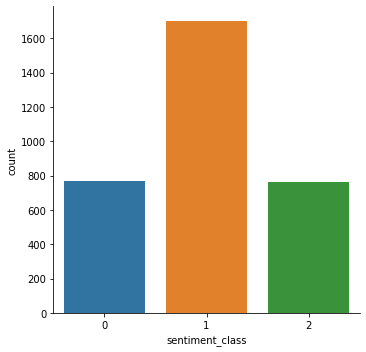

In [ ]:
#Plotting every class data in numbers
sns.catplot(x='sentiment_class',data=data,kind='count')

In [ ]:
data_0 = data.loc[data['sentiment_class']==0]
data_2 = data.loc[data['sentiment_class']==2]


#Oversampling the data
data_new = pd.concat([data,data_0,data_2])

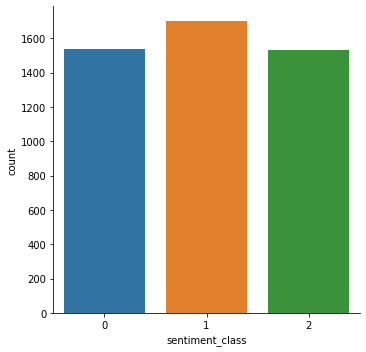

In [ ]:
#Plotting every class data in numbers
sns.catplot(x='sentiment_class',data=data_new,kind='count')

In [ ]:
data_train = data_new
data_train = shuffle(data_train)

data_train.sentiment_class.value_counts()

1    1701
0    1538
2    1530
Name: sentiment_class, dtype: int64

In [ ]:
data2 = pd.read_csv('test.csv')

In [ ]:
#data['original_text'] = [clean(i) for i in data['original_text']]
data2['original_text'] = [expand_words(i) for i in data2.original_text]

#data['original_text'] = [clean(i) for i in data['original_text']]
data2['original_text'] = clean(data2['original_text'])

data_test = data2
data_test.head(3)

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,3 yeah i once cooked potatoes when i was 3 ye...,en,0,LToddWood
1,1.245898e+18,happy mother s day to all the mums step mums ...,en,0,iiarushii
2,1.244717e+18,i love the people from the uk however when i ...,en,0,andreaanderegg


In [ ]:
x_test = data_test.original_text

In [ ]:

X = data_train.original_text
Y = data_train.sentiment_class

#Bekar Code

In [ ]:
vocab_size = 20000
embedding_dim = 200
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index



In [ ]:
len(word_index)

14838

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(training_padded, Y, 
                                                            random_state=42, test_size=0.2)

#Vectorization

In [ ]:
embeddings_index = {}
"""
f = open('glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()
"""
with open('glove.6B.200d.txt','r',encoding='utf-8') as f:
    for line in f:  # Every line contains word followed by the vector value
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [ ]:
num_tokens = min(len(word_index) + 1, vocab_size)
#num_tokens = len(word_index) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 7323 words (7515 misses)


In [ ]:
print(num_tokens)

14839


In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

testing_padded = np.array(testing_padded)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=num_tokens,
              output_dim=embedding_dim,
              input_length=max_length,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
#BEST MODEL
from tensorflow.keras import layers

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Dropout(0.5)(embedded_sequences)
x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.MaxPooling1D(3)(x)
#x = layers.Conv1D(128, 3, activation="relu")(x)
#x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(3, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=num_tokens,
              output_dim=embedding_dim,
              input_length=max_length,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:

from tensorflow.keras import layers

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
#x = layers.SpatialDropout1D(0.3)(embedded_sequences)
#x = layers.Bidirectional(layers.GRU(200, return_sequences=True))(x)
#x = layers.GlobalAveragePooling1D()(embedded_sequences)
x = layers.Dropout(0.5)(embedded_sequences)
x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.MaxPooling1D(3)(x)
#x = layers.Conv1D(128, 3, activation="relu")(x)
#x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(3, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_9 (Embedding)      (None, None, 200)         2967800   
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 128)         76928     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 128)               0  

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

In [ ]:
"""
optimizer = tf.keras.optimizers.RMSprop()#, epsilon=1e-08) #, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
 """ 

In [ ]:
BATCH_SIZE = 32

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=20, steps_per_epoch=n_steps, validation_data=(x_val, y_val))

Epoch 1/20
119/119 [==============================] - 1s 6ms/step - loss: 1.1333 - acc: 0.3330 - val_loss: 1.0998 - val_acc: 0.3522
Epoch 2/20
119/119 [==============================] - 1s 5ms/step - loss: 1.1012 - acc: 0.3545 - val_loss: 1.1007 - val_acc: 0.3323
Epoch 3/20
119/119 [==============================] - 1s 5ms/step - loss: 1.1013 - acc: 0.3566 - val_loss: 1.0978 - val_acc: 0.3532
Epoch 4/20
119/119 [==============================] - 1s 5ms/step - loss: 1.0997 - acc: 0.3603 - val_loss: 1.1015 - val_acc: 0.3344
Epoch 5/20
119/119 [==============================] - 1s 5ms/step - loss: 1.0992 - acc: 0.3574 - val_loss: 1.0982 - val_acc: 0.3501
Epoch 6/20
119/119 [==============================] - 1s 5ms/step - loss: 1.0995 - acc: 0.3534 - val_loss: 1.0976 - val_acc: 0.3522
Epoch 7/20
119/119 [==============================] - 1s 5ms/step - loss: 1.0987 - acc: 0.3598 - val_loss: 1.0981 - val_acc: 0.3522
Epoch 8/20
119/119 [==============================] - 1s 5ms/step - loss: 1.

In [ ]:
#BEST RESULTS
n_steps = x_train.shape[0] // BATCH_SIZE

model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=20, steps_per_epoch=n_steps, validation_data=(x_val, y_val))

Epoch 1/20
119/119 [==============================] - 1s 6ms/step - loss: 1.1318 - acc: 0.3325 - val_loss: 1.0989 - val_acc: 0.3428
Epoch 2/20
119/119 [==============================] - 1s 5ms/step - loss: 1.1047 - acc: 0.3529 - val_loss: 1.1028 - val_acc: 0.3208
Epoch 3/20
119/119 [==============================] - 1s 5ms/step - loss: 1.0999 - acc: 0.3550 - val_loss: 1.0978 - val_acc: 0.3449
Epoch 4/20
119/119 [==============================] - 1s 5ms/step - loss: 1.1006 - acc: 0.3532 - val_loss: 1.0981 - val_acc: 0.3459
Epoch 5/20
119/119 [==============================] - 1s 5ms/step - loss: 1.1017 - acc: 0.3547 - val_loss: 1.0948 - val_acc: 0.3606
Epoch 6/20
119/119 [==============================] - 1s 5ms/step - loss: 1.0977 - acc: 0.3603 - val_loss: 1.1005 - val_acc: 0.3260
Epoch 7/20
119/119 [==============================] - 1s 5ms/step - loss: 1.0992 - acc: 0.3635 - val_loss: 1.0982 - val_acc: 0.3459
Epoch 8/20
119/119 [==============================] - 1s 5ms/step - loss: 1.

In [ ]:

n_steps = x_val.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=2*2
)

In [ ]:
y_pred = model.predict(testing_padded)
y_pred2 = [np.argmax(i) for i in y_pred]

In [ ]:
y_pred3 = [i-1 for i in y_pred2]
print(y_pred3)

[0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, -1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 1, 0, -1, 1, 0, -1, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, -1, 0, 0, -1, -1, 0, -1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, -1, 0, -1, 1, 0, 1, -1, -1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, -1, 0, 0, -1, -1, -1, 0, 0, 1, 0, -1, 0, 1, 0, -1, 1, 0, -1, -1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, -1, 1, 0, 0, 0, 0, 0, -1, 0, -1, 0, 1, 1, -1, 1, -1, 0, 0, 1, 1, 0, -1, -1, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 1, 0, 0, -1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, -1, 1, 0, -1, 1, -1, 0, 0, 1, -1, 1, -1, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 1, 0, 0, -1, 1, 1, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, -1, 0, 0, 1, 1, 0, 0, -1, 1, 0, 0, 0, 0, -1, 0, 1, -1, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 

In [ ]:
data_test_ = data_test

In [ ]:
a = []
for ind in data_test.index:
  #data_test_['id,sentiment_class'] = (data_test['id'][ind],y_pred3[ind])
  b = (data_test['id'][ind],y_pred3[ind])
  #print(ind , '  ',b)
  a.append(b)

In [ ]:
df = pd.DataFrame(a,columns=['id','sentiment_class'])
df.head(3)

,id,sentiment_class
0,1.246628e+18,0
1,1.245898e+18,0
2,1.244717e+18,0


In [ ]:
df.sentiment_class.value_counts()

 0    894
-1    283
 1    210
Name: sentiment_class, dtype: int64

In [ ]:

#BEST RESULT 
df.sentiment_class.value_counts()

 0    792
 1    318
-1    277
Name: sentiment_class, dtype: int64

In [ ]:
df.to_csv('submission2300.csv',index = False)